In [50]:
from lib.scraping import *
from lib.get_config import *
import matplotlib.pyplot as plt

In [52]:
scraper = Scraper(
        teff_min = 5100,
        teff_max = 5200,
        logg_min = 4,
        logg_max = 4.5,
        feh_min = 0,
        feh_max = 0.5
    )

=========================== Initializing Scraper ===========================



In [53]:
teff_range = scraper.get_param_range('teff')
teff_range

array([  400.,   500.,   600.,   700.,   800.,   900.,  1000.,  1100.,
        1200.,  1300.,  1400.,  1500.,  1600.,  1700.,  1800.,  1900.,
        2000.,  2100.,  2200.,  2300.,  2400.,  2500.,  2600.,  2700.,
        2800.,  2900.,  3000.,  3100.,  3200.,  3300.,  3400.,  3500.,
        3600.,  3700.,  3800.,  3900.,  4000.,  4100.,  4200.,  4300.,
        4400.,  4500.,  4600.,  4700.,  4800.,  4900.,  5000.,  5100.,
        5200.,  5300.,  5400.,  5500.,  5600.,  5700.,  5800.,  5900.,
        6000.,  6100.,  6200.,  6300.,  6400.,  6500.,  6600.,  6700.,
        6800.,  6900.,  7000.,  7200.,  7400.,  7600.,  7800.,  8000.,
        8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,  9600.,
        9800., 10000., 10200., 10400., 10600., 10800., 11000., 11200.,
       11400., 11600., 11800., 12000., 12500., 13000., 13500., 14000.,
       14500., 15000., 15500., 16000., 16500., 17000., 17500., 18000.,
       18500., 19000., 19500., 20000., 21000., 22000., 23000., 24000.,
      

In [54]:
logg_range = scraper.get_param_range('logg')
logg_range

array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,
        5. ,  5.5,  6. ])

In [55]:
feh_range = scraper.get_param_range('meta')
feh_range

array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.3,  0.5])

In [56]:
def get_param_step(param_range):

    return {i: abs(i-j) for i, j in zip(param_range, param_range[1:])}

In [57]:
teff_step = get_param_step(teff_range)
teff_step

{400.0: 100.0,
 500.0: 100.0,
 600.0: 100.0,
 700.0: 100.0,
 800.0: 100.0,
 900.0: 100.0,
 1000.0: 100.0,
 1100.0: 100.0,
 1200.0: 100.0,
 1300.0: 100.0,
 1400.0: 100.0,
 1500.0: 100.0,
 1600.0: 100.0,
 1700.0: 100.0,
 1800.0: 100.0,
 1900.0: 100.0,
 2000.0: 100.0,
 2100.0: 100.0,
 2200.0: 100.0,
 2300.0: 100.0,
 2400.0: 100.0,
 2500.0: 100.0,
 2600.0: 100.0,
 2700.0: 100.0,
 2800.0: 100.0,
 2900.0: 100.0,
 3000.0: 100.0,
 3100.0: 100.0,
 3200.0: 100.0,
 3300.0: 100.0,
 3400.0: 100.0,
 3500.0: 100.0,
 3600.0: 100.0,
 3700.0: 100.0,
 3800.0: 100.0,
 3900.0: 100.0,
 4000.0: 100.0,
 4100.0: 100.0,
 4200.0: 100.0,
 4300.0: 100.0,
 4400.0: 100.0,
 4500.0: 100.0,
 4600.0: 100.0,
 4700.0: 100.0,
 4800.0: 100.0,
 4900.0: 100.0,
 5000.0: 100.0,
 5100.0: 100.0,
 5200.0: 100.0,
 5300.0: 100.0,
 5400.0: 100.0,
 5500.0: 100.0,
 5600.0: 100.0,
 5700.0: 100.0,
 5800.0: 100.0,
 5900.0: 100.0,
 6000.0: 100.0,
 6100.0: 100.0,
 6200.0: 100.0,
 6300.0: 100.0,
 6400.0: 100.0,
 6500.0: 100.0,
 6600.0: 100.0

In [58]:
logg_step = get_param_step(logg_range)
logg_step

{-0.5: 0.5,
 0.0: 0.5,
 0.5: 0.5,
 1.0: 0.5,
 1.5: 0.5,
 2.0: 0.5,
 2.5: 0.5,
 3.0: 0.5,
 3.5: 0.5,
 4.0: 0.5,
 4.5: 0.5,
 5.0: 0.5,
 5.5: 0.5}

In [59]:
feh_step = get_param_step(feh_range)
feh_step

{-4.0: 0.5,
 -3.5: 0.5,
 -3.0: 0.5,
 -2.5: 0.5,
 -2.0: 0.5,
 -1.5: 0.5,
 -1.0: 0.5,
 -0.5: 0.5,
 0.0: 0.3,
 0.3: 0.2}

In [60]:
def get_closest_value(value, array):

    if value > max(array) or value < min(array):

        print('Input value not in parameter range.')
        return None

    else:

        idx = (np.abs(array - value)).argmin()
        return array[idx]

In [61]:
# Getting user data
config = get_config()

# Getting targets
targets_path = config['USER_DATA']['targets_path']
targets = pd.read_csv(targets_path)
target = targets.loc[targets['star'] == 'CoRoT-1']

In [62]:
params = {
            'teff': target['teff'].item(),
            'logg': target['logg'].item(),
            # 'feh': target['feh'].item()
            'meta': 0.1
        }
params

{'teff': 6000, 'logg': 4.25, 'meta': 0.1}

In [63]:
list(params.keys())

['teff', 'logg', 'meta']

In [66]:
def get_delta_params():

    delta_params = {}

    for param in list(params.keys()):

        param_range = scraper.get_param_range(param)
        param_step = get_param_step(param_range)

        delta_params[param] = param_step.get(get_closest_value(params[param], param_range))

    return delta_params


In [67]:
get_delta_params()

{'teff': 100.0, 'logg': 0.5, 'meta': 0.3}

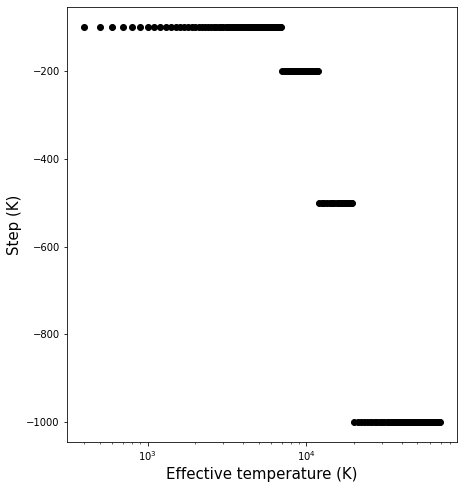

In [20]:
fig, ax = plt.subplots(figsize=(7,8), facecolor='white')

plt.plot(teff_range[:-1], teff_step, 'ko')

plt.xscale('log')

plt.xlabel('Effective temperature (K)', fontsize=15)
plt.ylabel('Step (K)', fontsize=15)

plt.show()

# Selenium

In [51]:
import pandas as pd
import numpy as np
import time
import ast
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

In [5]:
intervals = {
    'teff': {'min': 5100,'max': 5200},
    'logg': {'min': 4, 'max': 4.5},
    'meta': {'min': 0, 'max': 0.5}
    }

In [22]:
service = Service()

options = webdriver.ChromeOptions()

driver = webdriver.Chrome(service=service, options=options)

model = 'bt-settl'
url = f'https://svo2.cab.inta-csic.es/theory/newov2/index.php?models={model}'

driver.get(url)

In [72]:
def get_param_range(param, model='BT-Settl'):

    model = model.strip().lower()

    range_list = driver.find_element(By.NAME, f"params[{model}][{param}][min]").text.split('\n')

    return np.array([float(value) for value in range_list])

In [78]:
labels = {param: name for param, name in zip(list(intervals.keys()), ['Effective temperature (K)',
                                                                      'Surface gravity (dex)',
                                                                      'Metallicity (dex)'
                                                                     ])}
labels

{'teff': 'Effective temperature (K)',
 'logg': 'Surface gravity (dex)',
 'meta': 'Metallicity (dex)'}

In [79]:
delay = 1

for key, _ in intervals.items():

    select_min = Select(driver.find_element(By.NAME, f'params[{model}][{key}][min]'))
    select_max = Select(driver.find_element(By.NAME, f'params[{model}][{key}][max]'))

    select_min.select_by_visible_text(str(intervals[key]['min']))
    time.sleep(delay)

    select_max.select_by_visible_text(str(intervals[key]['max']))
    time.sleep(delay)


qtd = driver.find_element(By.NAME, 'nres')
select_qtd = Select(qtd)
select_qtd.select_by_value('all')

time.sleep(delay)

driver.find_element(By.XPATH, '/html/body/div[5]/table/tbody/tr/td/div/form/table/tbody/tr[1]/td[1]/table/tbody/tr[5]/td/input').click()


# Beautiful Soup

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import re
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [2]:
def get_soup(url, verify=False):

    site = requests.get(url, verify=verify)
    
    return BeautifulSoup(site.content, 'html.parser')

In [3]:
url = "https://svo2.cab.inta-csic.es/theory/newov2/"
soup = get_soup(url)

In [4]:
def get_model_url(soup, model='BT-Settl'):

    model_entries = soup.find_all('td', class_='mdls2_modtit')

    # Search for the model
    model_href = None
    for entry in model_entries:
        b_tag = entry.find('b')
        if b_tag and model in b_tag.text:
            a_tag = b_tag.find('a')
            if a_tag and 'href' in a_tag.attrs:
                model_href = a_tag['href']
                break
    
    # Print the result
    if model_href:
        
        # Construct full URL if needed (if the href is relative)
        if not model_href.startswith('http'):
            full_url = url + model_href.split("newov2/")[1]
            return full_url
    else:
        print(f"{model} model not found in the page.")
        return

In [5]:
new_url = get_model_url(soup)
new_url

'https://svo2.cab.inta-csic.es/theory/newov2/index.php?models=bt-settl'

In [6]:
model_soup = get_soup(new_url)

In [7]:
def submit_params(url, model='BT-Settl', teff_min=5000, teff_max=5100, logg_min=4, logg_max=4.5, meta_min=0, meta_max=0.5):

    model = model.lower()

    # Prepare the form data with your desired parameters
    form_data = {
        'models': ','+model,
        'oby': '',
        'odesc': '',
        'sbut': '',
        # Set Teff min and max
        f'params[{model}][teff][min]': str(teff_min),
        f'params[{model}][teff][max]': str(teff_max),
        # Set logg min and max
        f'params[{model}][logg][min]': str(logg_min),
        f'params[{model}][logg][max]': str(logg_max),
        # Set metallicity min and max
        f'params[{model}][meta][min]': str(meta_min),
        f'params[{model}][meta][max]': str(meta_max),
        # Show all results
        'nres': 'all',
        # Submit button
        'boton': 'Search',
        # Selected model
        'reqmodels[]': model
    }
    
    # Now follow the redirect if needed to get the actual content
    response = requests.post(url, data=form_data, allow_redirects=True, verify=False)

    if response.status_code == 200:

        print('Form submitted successfully!')
        return BeautifulSoup(response.text, 'html.parser')

    else:
        return

In [8]:
# Example usage
form_soup = submit_params(
    url = new_url,
    teff_min=5000, 
    teff_max=5100, 
    logg_min=4, 
    logg_max=4.5, 
    meta_min=0, 
    meta_max=0.5
)

Form submitted successfully!


In [9]:
def make_request(url, method='get', data=None):
    """Make a request with error handling"""
    try:
        if method.lower() == 'post':
            response = requests.post(url, data=data, verify=False, allow_redirects=True)
        else:
            response = requests.get(url, verify=False, allow_redirects=True)
        response.raise_for_status()
        return response
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

In [13]:
selected_models = []
rows = form_soup.select('table table tr')[1:]  # Skip header row

for i, row in enumerate(rows):
    cells = row.find_all('td')
    if len(cells) < 10:  # Skip non-data rows
        continue
    
    model = cells[0].get_text(strip=True)
    alpha = cells[4].get_text(strip=True)
    
    if model == "BT-Settl" and alpha == "0":
        ascii_link = cells[7].find('a')
        if ascii_link and 'href' in ascii_link.attrs:
            selected_models.append({
                'index': i,
                'model': model,
                'teff': cells[1].get_text(strip=True),
                'logg': cells[2].get_text(strip=True),
                'meta': cells[3].get_text(strip=True),
                'alpha': alpha,
                'ascii_link': url + ascii_link['href']
            })

if not selected_models:
    print("No matching models found with Alpha=0")
    exit()

original_form = form_soup.find('form', {'name': 'myform'})
form_action = url + original_form['action'].split("newov2/")[1]
original_data = {}

# Get hidden inputs and select values
for input_tag in original_form.find_all(['input', 'select']):
    if input_tag.name == 'input' and input_tag.get('type') == 'hidden':
        original_data[input_tag['name']] = input_tag.get('value', '')
    elif input_tag.name == 'select':
        selected_option = input_tag.find('option', selected=True)
        if selected_option:
            original_data[input_tag['name']] = selected_option.get('value', '')

# Step 2: Prepare data for retrieval (include original form data)
retrieve_data = original_data.copy()  # Keep all original selections

# Mark ASCII checkboxes for selected models
for model in selected_models:
    retrieve_data[f'txt[{model["index"]}]'] = 'on'

retrieve_data['boton'] = 'Retrieve'

# Step 7: Submit the retrieval request
print(f"Submitting retrieval request for {len(selected_models)} models...")
response = make_request(form_action, 'post', retrieve_data)
if not response:
    exit()

# # Step 8: Wait for server to prepare the download

# processing_delay = len(selected_models) * 3 # 3 seconds per model

# print(f"Waiting {processing_delay} seconds for server to prepare download...")
# time.sleep(processing_delay)

# # Step 9: Check for download link (you might need to reload the page)
# print("Checking for download link...")
# response = make_request(form_action)
# if not response:
#     exit()

soup = BeautifulSoup(response.text, 'html.parser')
download_link = soup.find('a', string=lambda t: t and 'Download tar file' in t)

if download_link and 'href' in download_link.attrs:
    download_url = download_link['href']
    print(f"Download URL found: {download_url}")
    
    # # Step 10: Download the file
    # print("Starting download...")
    # download_response = make_request(download_url)
    # if download_response:
    #     filename = f"bt_settl_models_{int(time.time())}.tar"
    #     with open(filename, 'wb') as f:
    #         f.write(download_response.content)
    #     print(f"Download completed! Saved as {filename}")
    # else:
    #     print("Failed to download file")
else:
    print("No download link found. Possible reasons:")
    print("- The server needs more time to prepare the files")
    print("- There might be an error in the request")
    print("- The page structure might have changed")

# Print selected models for verification
print("\nSelected models summary:")
for model in selected_models:
    print(f"Model: {model['model']}, Teff: {model['teff']}, Logg: {model['logg']}, "
          f"Metallicity: {model['meta']}, Alpha: {model['alpha']}")

Submitting retrieval request for 12 models...
Download URL found: https://svo2.cab.inta-csic.es//theory/newov2/temp/models/tar/models_1745273472.tgz

Selected models summary:
Model: BT-Settl, Teff: 5000, Logg: 4, Metallicity: 0, Alpha: 0
Model: BT-Settl, Teff: 5000, Logg: 4.5, Metallicity: 0.5, Alpha: 0
Model: BT-Settl, Teff: 5000, Logg: 4.5, Metallicity: 0.3, Alpha: 0
Model: BT-Settl, Teff: 5000, Logg: 4.5, Metallicity: 0, Alpha: 0
Model: BT-Settl, Teff: 5000, Logg: 4, Metallicity: 0.5, Alpha: 0
Model: BT-Settl, Teff: 5000, Logg: 4, Metallicity: 0.3, Alpha: 0
Model: BT-Settl, Teff: 5100, Logg: 4.5, Metallicity: 0.3, Alpha: 0
Model: BT-Settl, Teff: 5100, Logg: 4.5, Metallicity: 0, Alpha: 0
Model: BT-Settl, Teff: 5100, Logg: 4, Metallicity: 0.5, Alpha: 0
Model: BT-Settl, Teff: 5100, Logg: 4, Metallicity: 0.3, Alpha: 0
Model: BT-Settl, Teff: 5100, Logg: 4, Metallicity: 0, Alpha: 0
Model: BT-Settl, Teff: 5100, Logg: 4.5, Metallicity: 0.5, Alpha: 0
